# Análisis de Datos

## Trabajo Práctico Final
### Título: "Nutrition Facts for McDonald's Menu"

### Introducción
El presente informe corresponde al desarrollo de un estimador de la cantidad de calorías de cada ítem definido en el menú de McDonald's, en función de las prodiedades nutricionales que lo componen. Para ello, se utilizó el dataset [Nutrition Facts for McDonald's] (https://www.kaggle.com/datasets/mcdonalds/nutrition-facts/code?resource=download), publicado en el sitio web Kaggle.

El desarrollo del modelo se llevó a cabo siguiendo las siguientes etapas:
1. Análisis del dataset
2. Preparación del dataset
3. Ingeniería de Feactures
4. Aprendizaje y Entrenamieto de modelos
5. Evaluacion de la calidad de las predicciones

### 1. Análisis del Dataset

In [407]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

from dtreeviz.trees import dtreeviz

from xgboost import XGBClassifier

import itertools
import matplotlib.pyplot as plt

In [408]:
# carga del dataset
df = pd.read_csv("dataset/menu.csv")

In [409]:
# impresión en pantalla de de las cinco primeras feactures del dataset
df.head()

Category                              Item    Serving Size  Calories  \
0  Breakfast                      Egg McMuffin  4.8 oz (136 g)       300   
1  Breakfast                 Egg White Delight  4.8 oz (135 g)       250   
2  Breakfast                  Sausage McMuffin  3.9 oz (111 g)       370   
3  Breakfast         Sausage McMuffin with Egg  5.7 oz (161 g)       450   
4  Breakfast  Sausage McMuffin with Egg Whites  5.7 oz (161 g)       400   

   Calories from Fat  Total Fat  Total Fat (% Daily Value)  Saturated Fat  \
0                120       13.0                         20            5.0   
1                 70        8.0                         12            3.0   
2                200       23.0                         35            8.0   
3                250       28.0                         43           10.0   
4                210       23.0                         35            8.0   

   Saturated Fat (% Daily Value)  Trans Fat  ...  Carbohydrates  \
0                             25        0.0  ...             31   
1                             15        0.0  ...             30   
2                             42        0.0  ...             29   
3                             52        0.0  ...             30   
4                             42        0.0  ...             30   

   Carbohydrates (% Daily Value)  Dietary Fiber  \
0                             10              4   
1                             10              4   
2                             10              4   
3                             10              4   
4                             10              4   

   Dietary Fiber (% Daily Value)  Sugars  Protein  Vitamin A (% Daily Value)  \
0                             17       3       17                         10   
1                             17       3       18                          6   
2                             17       2       14                          8   
3                             17       2       21                         15   
4                             17       2       21                          6   

   Vitamin C (% Daily Value)  Calcium (% Daily Value)  Iron (% Daily Value)  
0                          0                       25                    15  
1                          0                       25                     8  
2                          0                       25                    10  
3                          0                       30                    15  
4                          0                       25                    10  

[5 rows x 24 columns]

In [410]:
df_row, df_col = df.shape
print('El dataset se compone de {} filas y {} columnas'.format(df_row, df_col))

El dataset se compone de 260 filas y 24 columnas


Considerando que la variable a predecir son las calorías de cada ítem definido en el menú, se desea saber qué distribución de probabilidad presenta esta variable. Para ello se grafica su histograma.

(-94.0, 1974.0, 0.0, 96.6)

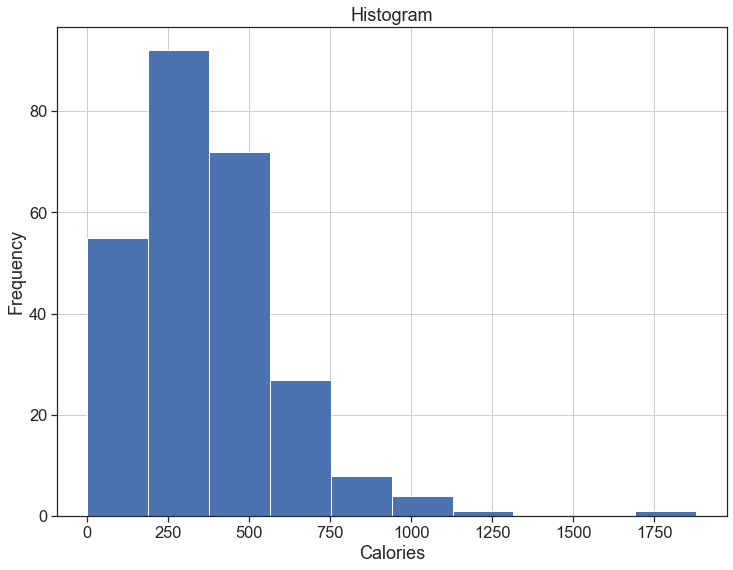

In [411]:
calories = df.Calories.to_numpy()
fig, ax = plt.subplots(1,figsize=(12,9))
ax.hist(calories)
ax.set_title("Histogram")
ax.set(ylabel='Frequency')
ax.set(xlabel='Calories')
ax.grid()
ax.axis('on')

Como se muestra en el diagrama, la distribución es asimétrica con un skew positivo.

### 2. Análisis Exploratorio Inicial

A contiación se analizan las principales caracterìsticas del dataset
• Visualizar las primeras filas.
• Realizar un resumen de 5 números.
• Identificar los tipos de datos: categórico, ordinal, etc. Responder para cada variable su tipo y si es informativa para un problema de clasificación (por ejemplo si se trata de un código, como una matrícula, o un nombre propio).
• Identificar las variables de entrada y de salida del problema.
• Variables de entrada:
o Realizar los siguientes análisis por tipo de variable:
• Numéricas: Obtener conclusiones acerca de la distribución de los datos.
• Categóricas: Obtener conclusiones acerca de la cardinalidad, representación de cada categoría, etc.
• Compuestas: ¿Pueden tratarse para utilizarse en el problema a resolver?
• Variables de salida (en caso de aplicar):
o ¿Están balanceadas las clases?
o (en caso de aplicar) ¿Qué técnicas consideraría para codificar la variable de salida? Justifique.

In [413]:
# impresión en pantalla de las caracterìsticas del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Category                       260 non-null    object 
 1   Item                           260 non-null    object 
 2   Serving Size                   260 non-null    object 
 3   Calories                       260 non-null    int64  
 4   Calories from Fat              260 non-null    int64  
 5   Total Fat                      260 non-null    float64
 6   Total Fat (% Daily Value)      260 non-null    int64  
 7   Saturated Fat                  260 non-null    float64
 8   Saturated Fat (% Daily Value)  260 non-null    int64  
 9   Trans Fat                      260 non-null    float64
 10  Cholesterol                    260 non-null    int64  
 11  Cholesterol (% Daily Value)    260 non-null    int64  
 12  Sodium                         260 non-null    int

El dataset se compone de  24 columnas y 260 filas, siendo las primeras las variables de entrada-salida, y las segundas, las observaciones. La variable de salida es numérica y corresponde a "Calories". El resto de las variables serán consideradas como entrada. En las misma puede notarse que solo tres son categóricas: 'Category', 'Item' y 'Serving Size'.

En particular, cada una de estas variables representa diferentes aspectos del dataset:
- 'Item': corresponde a un valor ordinal arbitrario mediante el cual se identifica de manera ùnivoca a cada uno de los elementros del dataset. Por lo tanto, no tiene influencia alguna sobre la variable de salida a predecir.

- 'Category': representa una agrupación de los ítems definidos en el dataset. Dado que el mismo se compone de diferentes alimentos, se establece mediante esta variable una agrupación de acuerdo al tipo de alimiento que se trate (café o te, bife o pollo, ect). Esta variable no tiene ninguna influencia sobre el cómputo de la variable de salida.

- 'Serving Size': hace referencia al tamaño de la porción en distintas unidades: gr, ml, oz, etc. A diferencia de las anteriores, su valor sí influye sobre el resultado de la salida.

Es importante notar que no existen valores faltantes para ningun tipo de variable que compone el dataset.

Con respecto a las variables numéricas, a continuación pueden observarse los principales estadísticos asociados a cada una de ellas:

In [414]:
# impresión en pantalla de los estadìsticos asociados a las variables numéricas
df.describe()

Calories  Calories from Fat   Total Fat  Total Fat (% Daily Value)  \
count   260.000000         260.000000  260.000000                 260.000000   
mean    368.269231         127.096154   14.165385                  21.815385   
std     240.269886         127.875914   14.205998                  21.885199   
min       0.000000           0.000000    0.000000                   0.000000   
25%     210.000000          20.000000    2.375000                   3.750000   
50%     340.000000         100.000000   11.000000                  17.000000   
75%     500.000000         200.000000   22.250000                  35.000000   
max    1880.000000        1060.000000  118.000000                 182.000000   

       Saturated Fat  Saturated Fat (% Daily Value)   Trans Fat  Cholesterol  \
count     260.000000                     260.000000  260.000000   260.000000   
mean        6.007692                      29.965385    0.203846    54.942308   
std         5.321873                      26.639209    0.429133    87.269257   
min         0.000000                       0.000000    0.000000     0.000000   
25%         1.000000                       4.750000    0.000000     5.000000   
50%         5.000000                      24.000000    0.000000    35.000000   
75%        10.000000                      48.000000    0.000000    65.000000   
max        20.000000                     102.000000    2.500000   575.000000   

       Cholesterol (% Daily Value)       Sodium  ...  Carbohydrates  \
count                   260.000000   260.000000  ...     260.000000   
mean                     18.392308   495.750000  ...      47.346154   
std                      29.091653   577.026323  ...      28.252232   
min                       0.000000     0.000000  ...       0.000000   
25%                       2.000000   107.500000  ...      30.000000   
50%                      11.000000   190.000000  ...      44.000000   
75%                      21.250000   865.000000  ...      60.000000   
max                     192.000000  3600.000000  ...     141.000000   

       Carbohydrates (% Daily Value)  Dietary Fiber  \
count                     260.000000     260.000000   
mean                       15.780769       1.630769   
std                         9.419544       1.567717   
min                         0.000000       0.000000   
25%                        10.000000       0.000000   
50%                        15.000000       1.000000   
75%                        20.000000       3.000000   
max                        47.000000       7.000000   

       Dietary Fiber (% Daily Value)      Sugars     Protein  \
count                     260.000000  260.000000  260.000000   
mean                        6.530769   29.423077   13.338462   
std                         6.307057   28.679797   11.426146   
min                         0.000000    0.000000    0.000000   
25%                         0.000000    5.750000    4.000000   
50%                         5.000000   17.500000   12.000000   
75%                        10.000000   48.000000   19.000000   
max                        28.000000  128.000000   87.000000   

       Vitamin A (% Daily Value)  Vitamin C (% Daily Value)  \
count                 260.000000                 260.000000   
mean                   13.426923                   8.534615   
std                    24.366381                  26.345542   
min                     0.000000                   0.000000   
25%                     2.000000                   0.000000   
50%                     8.000000                   0.000000   
75%                    15.000000                   4.000000   
max                   170.000000                 240.000000   

       Calcium (% Daily Value)  Iron (% Daily Value)  
count               260.000000            260.000000  
mean                 20.973077              7.734615  
std                  17.019953              8.723263  
min                   0.000000              0.000000  
25%         

#### 2.1. Variables categóricas
A continuación se analizará en profundidad cada una de las variables categóricas que componen el dataset a los fines de interpretar mejor su naturaleza, analizar su impacto sobre la variable de salida y determinar qué tipo de tratamiento se le dará (si será omitida; o bien, codificada e incuida en el dataset).

La varible 'Item' será omitida, ya que al ser una asignación numérica adbitraria a los elementos del dataset, no tiene ninguna influencia sobre el cómputo de la variable de salida. Lo mismo ocurre en el caso de la variable 'Category', la cual establece una agrupación de los alimentos que no tiene vinculación alguna con la cantidad de calorías que contienen, como se muestra a continuación.

In [415]:
print("Clases definidas en la variable de entrada 'Category': {}".format(df.Category.unique()))

Clases definidas en la variable de entrada 'Category': ['Breakfast' 'Beef & Pork' 'Chicken & Fish' 'Salads' 'Snacks & Sides'
 'Desserts' 'Beverages' 'Coffee & Tea' 'Smoothies & Shakes']


Por su parte, la variable 'Serving Size' muestra un valor cuantitativo que muestra el peso de cada ítem en distintas unidades de medida. A continuación se muestra la lista de valores que asume esta variable:

In [416]:
print("Valores distintos que asume la variable 'Serving Size':")
df['Serving Size'].unique

Valores distintos que asume la variable 'Serving Size':


<bound method Series.unique of 0       4.8 oz (136 g)
1       4.8 oz (135 g)
2       3.9 oz (111 g)
3       5.7 oz (161 g)
4       5.7 oz (161 g)
            ...       
255    10.1 oz (285 g)
256    13.4 oz (381 g)
257     6.7 oz (190 g)
258    14.2 oz (403 g)
259     7.1 oz (202 g)
Name: Serving Size, Length: 260, dtype: object>

Se observa que la variable toma un valor diferente para cada observaciòn. Sin embargo, al estar expresadas las catidades en unidades, es posible transformarlas a numéricas, separándolas en grupos de acuerdo a la unidad en la que está expresada cada una y posteriormente aplicándoles la transformación correspondiente para llevarlas a gramos.

Para ésto se plantea la siguiente estragia: se filtratan solo los caracteres alfabéticos de cada observacion, y luego se los agrupará por clase.

In [417]:
# Función para filtrar caracteres alfabéticos de una cadena de strings
def word_filter (str_list):
    new_str_list = []    
    for i in range (len(str_list)):
        new_strg = ''
        for j in str_list[i]:
            if (j.isalpha()):
                new_strg+=j
        new_str_list.append(new_strg)
    return new_str_list

In [418]:
# Se define una variable auxiliar 'Serving Size (str)' para almacenar las etiquetas generadas por el filtrado anterior.
df['Serving Size (str)'] = word_filter(df['Serving Size'])
serving_size_unit = df['Serving Size (str)'].unique()

print("Analizando las unidades de medida de la variable categórica 'Serving Size', se encontró {} unidades de medida distintas, siendo las mismas las siguientes:".format(len(serving_size_unit)))
print(serving_size_unit)

Analizando las unidades de medida de la variable categórica 'Serving Size', se encontró 6 unidades de medida distintas, siendo las mismas las siguientes:
['ozg' 'cookieg' 'flozcup' 'cartonml' 'flozml' 'floz']


Para entender mejor los valores de las nuevas etiquetas generadas, se losanaliza uno a uno a continuación:

In [422]:
# Filtrado de datos pertenecientes a la clase ['Serving Size (str)']='ozg'
idx_serving_size_tag_0 = []

for i in range (len(df['Serving Size (str)'])):
    if (df['Serving Size (str)'][i] == serving_size_unit[0]):
        idx_serving_size_tag_0.append(i)

print("Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta '{}':".format(serving_size_unit[0]))
print(df['Serving Size'][idx_serving_size_tag_0])

Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta 'ozg':
0       4.8 oz (136 g)
1       4.8 oz (135 g)
2       3.9 oz (111 g)
3       5.7 oz (161 g)
4       5.7 oz (161 g)
            ...       
255    10.1 oz (285 g)
256    13.4 oz (381 g)
257     6.7 oz (190 g)
258    14.2 oz (403 g)
259     7.1 oz (202 g)
Name: Serving Size, Length: 116, dtype: object


En este caso, puede verse que la etiqueta 'ozg', corresponde a las unidades onzas y gramos. Dado que el objetivo es transformar este valor en gramos, solo será necesario filtrar el valor numérico definido entre paréntesis para lograrlo. 

In [423]:
# Función que filtra el número entre los caracteres '(' y ' '.
def number_filter (data_str):
    if (data_str.find('(') != -1):
        idx = data_str.find('(')
        data_number = ''
        i=1
        while (i>0):
            if (data_str[idx + i].isdigit()):
                data_number+=data_str[idx + i]
                i+=1
            else:
                i=-1
    return data_number

In [424]:
# Obtención de los valores numéricos filtrados
data_serving_size_tag_0 = []

for i in idx_serving_size_tag_0:
    if (df['Serving Size'][i].find('(') != -1):
        data_number = number_filter(df['Serving Size'][i])
    data_serving_size_tag_0.append(float(data_number))

De igual manera se continua con las siguientes clases definidas en 'Serving Size (str)'.

In [427]:
# Filtrado de datos pertenecientes a la clase ['Serving Size (str)']='cookieg'
idx_serving_size_tag_1 = []

for i in range (len(df['Serving Size (str)'])):
    if (df['Serving Size (str)'][i] == serving_size_unit[1]):
        idx_serving_size_tag_1.append(i)

print("Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta '{}':".format(serving_size_unit[1]))
print(df['Serving Size'][idx_serving_size_tag_1])

Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta 'cookieg':
104    1 cookie (33 g)
105    1 cookie (33 g)
Name: Serving Size, dtype: object


Este caso es similar al anterior: el dato correspondiente al peso ya se encuentra en la unidad esperada (g) y está definido entre los caracteres '(' y ' '. De manera que se procede exactamente igual que el caso anterior: filtrando el dato numérico entre paréntesis.

In [426]:
# Obtención de los valores numéricos filtrados
data_serving_size_tag_1 = []

for i in idx_serving_size_tag_1:
    if (df['Serving Size'][i].find('(') != -1):
        data_number = number_filter(df['Serving Size'][i])
    data_serving_size_tag_1.append(float(data_number))

In [428]:
# Filtrado de datos pertenecientes a la clase ['Serving Size (str)']='flozcup'
idx_serving_size_tag_2 = []

for i in range (len(df['Serving Size (str)'])):
    if (df['Serving Size (str)'][i] == serving_size_unit[2]):
        idx_serving_size_tag_2.append(i)

print("Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta '{}':".format(serving_size_unit[2]))
print(df['Serving Size'][idx_serving_size_tag_2])

Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta 'flozcup':
110    16 fl oz cup
111    21 fl oz cup
112    30 fl oz cup
113    12 fl oz cup
114    16 fl oz cup
           ...     
247    12 fl oz cup
248    16 fl oz cup
249    22 fl oz cup
250    16 fl oz cup
251    22 fl oz cup
Name: Serving Size, Length: 138, dtype: object


Los datos cuya cantidad se expresa en esta medida, se listan a continuacion:

In [438]:
print(df['Item'][idx_serving_size_tag_2])

110     Coca-Cola Classic (Small)
111    Coca-Cola Classic (Medium)
112     Coca-Cola Classic (Large)
113     Coca-Cola Classic (Child)
114             Diet Coke (Small)
                  ...            
247       Chocolate Shake (Small)
248      Chocolate Shake (Medium)
249       Chocolate Shake (Large)
250       Shamrock Shake (Medium)
251        Shamrock Shake (Large)
Name: Item, Length: 138, dtype: object


En este caso puede verse que la medida 'fl oz cup' corresponde a una unidad de volumen, y dado que se desea transformar el dato de salida a una unidad de masa 'g', es necesario analizar la naturaleza del líquido dado que el valor de la densidad será distinto para cada caso. teniendo en cuenta ésto, se analizan las etiquetas asignadas a cada ítem para obtener más información acerca de los líquidos considerados.

In [336]:
print(df['Item'][idx_serving_size_tag_2].unique())

['Coca-Cola Classic (Small)' 'Coca-Cola Classic (Medium)'
 'Coca-Cola Classic (Large)' 'Coca-Cola Classic (Child)'
 'Diet Coke (Small)' 'Diet Coke (Medium)' 'Diet Coke (Large)'
 'Diet Coke (Child)' 'Dr Pepper (Small)' 'Dr Pepper (Medium)'
 'Dr Pepper (Large)' 'Dr Pepper (Child)' 'Diet Dr Pepper (Small)'
 'Diet Dr Pepper (Medium)' 'Diet Dr Pepper (Large)'
 'Diet Dr Pepper (Child)' 'Sprite (Small)' 'Sprite (Medium)'
 'Sprite (Large)' 'Sprite (Child)' 'Minute Maid Orange Juice (Small)'
 'Minute Maid Orange Juice (Medium)' 'Minute Maid Orange Juice (Large)'
 'Iced Tea (Small)' 'Iced Tea (Medium)' 'Iced Tea (Large)'
 'Iced Tea (Child)' 'Sweet Tea (Small)' 'Sweet Tea (Medium)'
 'Sweet Tea (Large)' 'Sweet Tea (Child)' 'Coffee (Small)'
 'Coffee (Medium)' 'Coffee (Large)' 'Latte (Small)' 'Latte (Medium)'
 'Latte (Large)' 'Caramel Latte (Small)' 'Caramel Latte (Medium)'
 'Caramel Latte (Large)' 'Hazelnut Latte (Small)'
 'Hazelnut Latte (Medium)' 'Hazelnut Latte (Large)'
 'French Vanilla Latte (S

A grandes rasgos se observa que hay distintos tipos de lìquidos incluídos en el menú, sindo los mayoritarios los siguientes: 
- Bebidas de distinto tipo (con y sin azucar)
- infusiones (té, café, etc)
- leche
- batidos

Dedido a que el valor de la densidad no está explicitado en el dataset, y si bien el mismo podría estimarse haciendo uso de datos tabulares teóricos, suponiendo una composición para cada alimento, resulta laborioso hacerlo y es posible que no aporte gran informaciòn respecto a la variable que se pretende estimar. De manera que, a los fines de simplificar el análisis y obtener una valor numérico aproximado para esta variable, se parte utilizará para el cálculo la misma densidad para todas las observaciones, y será la correspondiente al agua, cuyo valor es 1.

Considerando la siguiente equivalencia, es posible cambiar la unidad [fl oz cup] a [g], considerando que la densidad no varía demasiado con respecto a la del agua:

1 [cup] = 8 [fl oz] = 8 * 0,0339 [g] = 0,2712 [g]

o lo que es lo mismo,

1 [g] = 3,6873 [cup]

Aplicando la transformación correspondiente resulta:

In [439]:
def fl_oz_cup_to_gr (data_str):
    data_number = ''
    i = 0
    while (i>-1):
        if (data_str[i].isdigit()):
            data_number+=data_str[i]
            i+=1
        else:
            i=-1
        data_number_gr = float(float(data_number)*3.6873)
    return data_number_gr

In [441]:
data_serving_size_tag_2 = []

for i in idx_serving_size_tag_2:
    data_number = fl_oz_cup_to_gr(df['Serving Size'][i])
    data_serving_size_tag_2.append(float(data_number))

In [339]:
# Filtrado de datos pertenecientes a la clase ['Serving Size (str)']='cartonml'
idx_serving_size_tag_3 = []

for i in range (len(df['Serving Size (str)'])):
    if (df['Serving Size (str)'][i] == serving_size_unit[3]):
        idx_serving_size_tag_3.append(i)

print("Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta '{}':".format(serving_size_unit[3]))
print(df['Serving Size'][idx_serving_size_tag_3])

Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta 'cartonml':
130    1 carton (236 ml)
131    1 carton (236 ml)
Name: Serving Size, dtype: object


In [340]:
print(df['Item'][idx_serving_size_tag_3].unique())

['1% Low Fat Milk Jug' 'Fat Free Chocolate Milk Jug']


En este otro caso, continuando con el supuesto que la densidad se mantendrá invariante e igual a la del agua, se puede obtener el valor en gramos a partir de la medida expresada en 'ml'. Dado que el valor que ya forma parte del dato y se encuentra entre paréntesis, solo es necesario filtrarlo.

In [341]:
data_serving_size_tag_3 = []

for i in idx_serving_size_tag_3:
    if (df['Serving Size'][i].find('(') != -1):
        data_number = number_filter(df['Serving Size'][i])
    data_serving_size_tag_3.append(float(data_number))

In [443]:
# Filtrado de datos pertenecientes a la clase ['Serving Size (str)']='flozml'
idx_serving_size_tag_4 = []

for i in range (len(df['Serving Size (str)'])):
    if (df['Serving Size (str)'][i] == serving_size_unit[4]):
        idx_serving_size_tag_4.append(i)

print("Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta '{}':".format(serving_size_unit[4]))
print(df['Serving Size'][idx_serving_size_tag_4])

Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta 'flozml':
132    6 fl oz (177 ml)
Name: Serving Size, dtype: object


In [444]:
data_serving_size_tag_4 = []

for i in idx_serving_size_tag_4:
    if (df['Serving Size'][i].find('(') != -1):
        data_number = number_filter(df['Serving Size'][i])
    data_serving_size_tag_4.append(float(data_number))

In [445]:
# Filtrado de datos pertenecientes a la clase ['Serving Size (str)']='floz'
idx_serving_size_tag_5 = []

for i in range (len(df['Serving Size (str)'])):
    if (df['Serving Size (str)'][i] == serving_size_unit[5]):
        idx_serving_size_tag_5.append(i)

print("Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta '{}':".format(serving_size_unit[5]))
print(df['Serving Size'][idx_serving_size_tag_5])

Data Frame filtrado por los valores de la columna 'Serving Size (str)' iguales a la etiqueta 'floz':
136    16.9 fl oz
Name: Serving Size, dtype: object


In [450]:
# Función para convertir [fl oz] a [g]
def fl_oz_to_gr (data_str):
    data_number = ''
    i = 0
    while (i>-1):
        if (data_str[i].isdigit()):
            data_number+=data_str[i]
            i+=1
        else:
            i=-1
        data_number_gr = float(float(data_number)*0.0339)
    return data_number_gr

In [451]:
data_serving_size_tag_5 = []

for i in idx_serving_size_tag_5:
    data_number = fl_oz_to_gr(df['Serving Size'][i])
    data_serving_size_tag_5.append(float(data_number))

Con los valores calculados anteriormente se agrega una nueva columna al dataset la cual corresponde a la variable numérica 'Serving Size (gr)', que a su vez reemplazará a la veriable categórica 'Serving Size'

In [454]:
serving_size_gr = np.zeros(len(df['Serving Size']), dtype=float)
serving_size_gr[idx_serving_size_tag_0] = data_serving_size_tag_0
serving_size_gr[idx_serving_size_tag_1] = data_serving_size_tag_1
serving_size_gr[idx_serving_size_tag_2] = data_serving_size_tag_2
serving_size_gr[idx_serving_size_tag_3] = data_serving_size_tag_3
serving_size_gr[idx_serving_size_tag_4] = data_serving_size_tag_4
serving_size_gr[idx_serving_size_tag_5] = data_serving_size_tag_5

df['Serving Size (gr)'] = serving_size_gr

De manera que el dataset modificado resulta:

In [455]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Category                       260 non-null    object 
 1   Item                           260 non-null    object 
 2   Serving Size                   260 non-null    object 
 3   Calories                       260 non-null    int64  
 4   Calories from Fat              260 non-null    int64  
 5   Total Fat                      260 non-null    float64
 6   Total Fat (% Daily Value)      260 non-null    int64  
 7   Saturated Fat                  260 non-null    float64
 8   Saturated Fat (% Daily Value)  260 non-null    int64  
 9   Trans Fat                      260 non-null    float64
 10  Cholesterol                    260 non-null    int64  
 11  Cholesterol (% Daily Value)    260 non-null    int64  
 12  Sodium                         260 non-null    int

Habiendo convrtido a numérica la única variable categórica que tenía impacto sobre el cómputo de la salida, se eliminan del dataset las variables auxiliares creadas anteriormente ('Serving Size' y 'Serving Size (str)') y las categóricas en desuso ('Category' y 'Item').

In [456]:
df_num = df.drop(['Category', 'Item', 'Serving Size', 'Serving Size (str)'], axis = 1, inplace = False)
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Calories                       260 non-null    int64  
 1   Calories from Fat              260 non-null    int64  
 2   Total Fat                      260 non-null    float64
 3   Total Fat (% Daily Value)      260 non-null    int64  
 4   Saturated Fat                  260 non-null    float64
 5   Saturated Fat (% Daily Value)  260 non-null    int64  
 6   Trans Fat                      260 non-null    float64
 7   Cholesterol                    260 non-null    int64  
 8   Cholesterol (% Daily Value)    260 non-null    int64  
 9   Sodium                         260 non-null    int64  
 10  Sodium (% Daily Value)         260 non-null    int64  
 11  Carbohydrates                  260 non-null    int64  
 12  Carbohydrates (% Daily Value)  260 non-null    int

A continuación se muestra la representación gráfica de las distribuciones de probabilidad de cada variable que compone el data set:

In [457]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

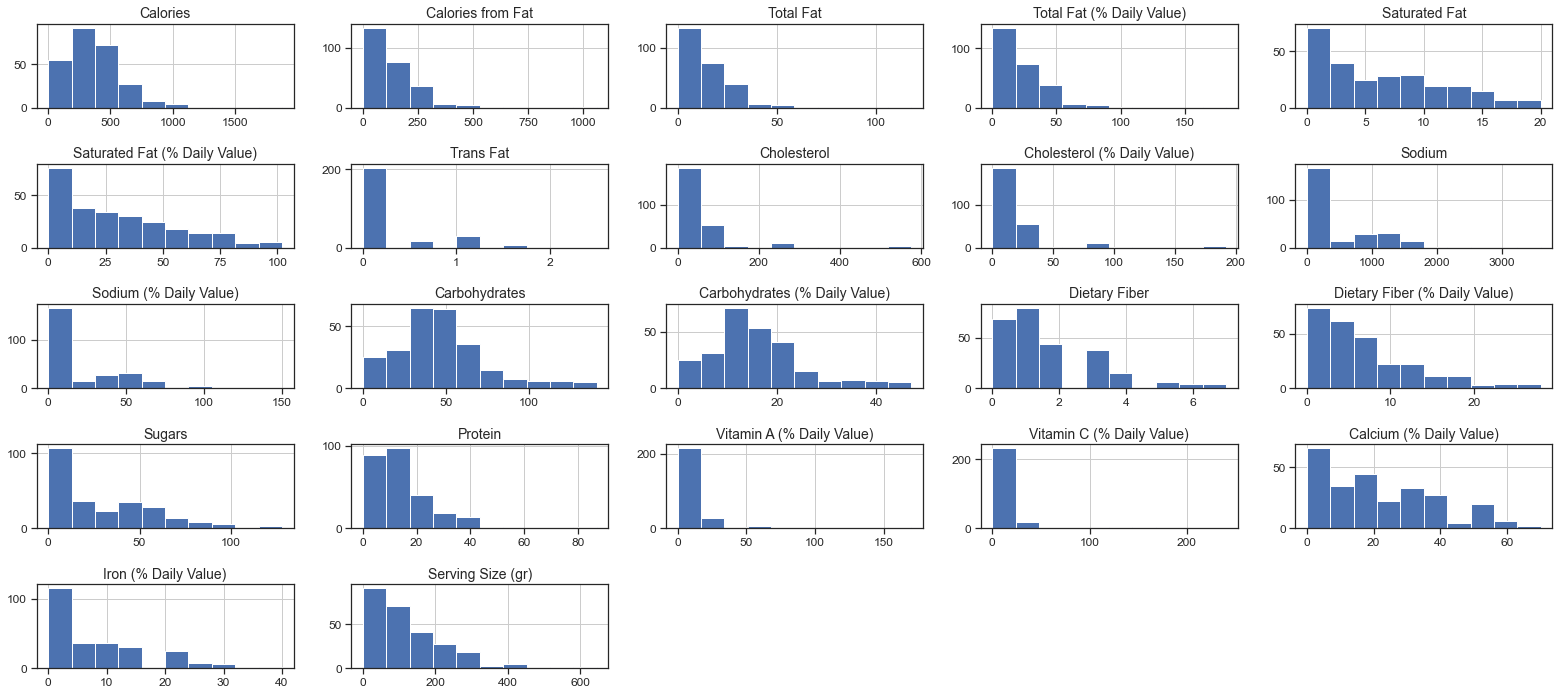

In [458]:
display_dataset_distributions(df_num)

#### Análisis de correlación entre las variables

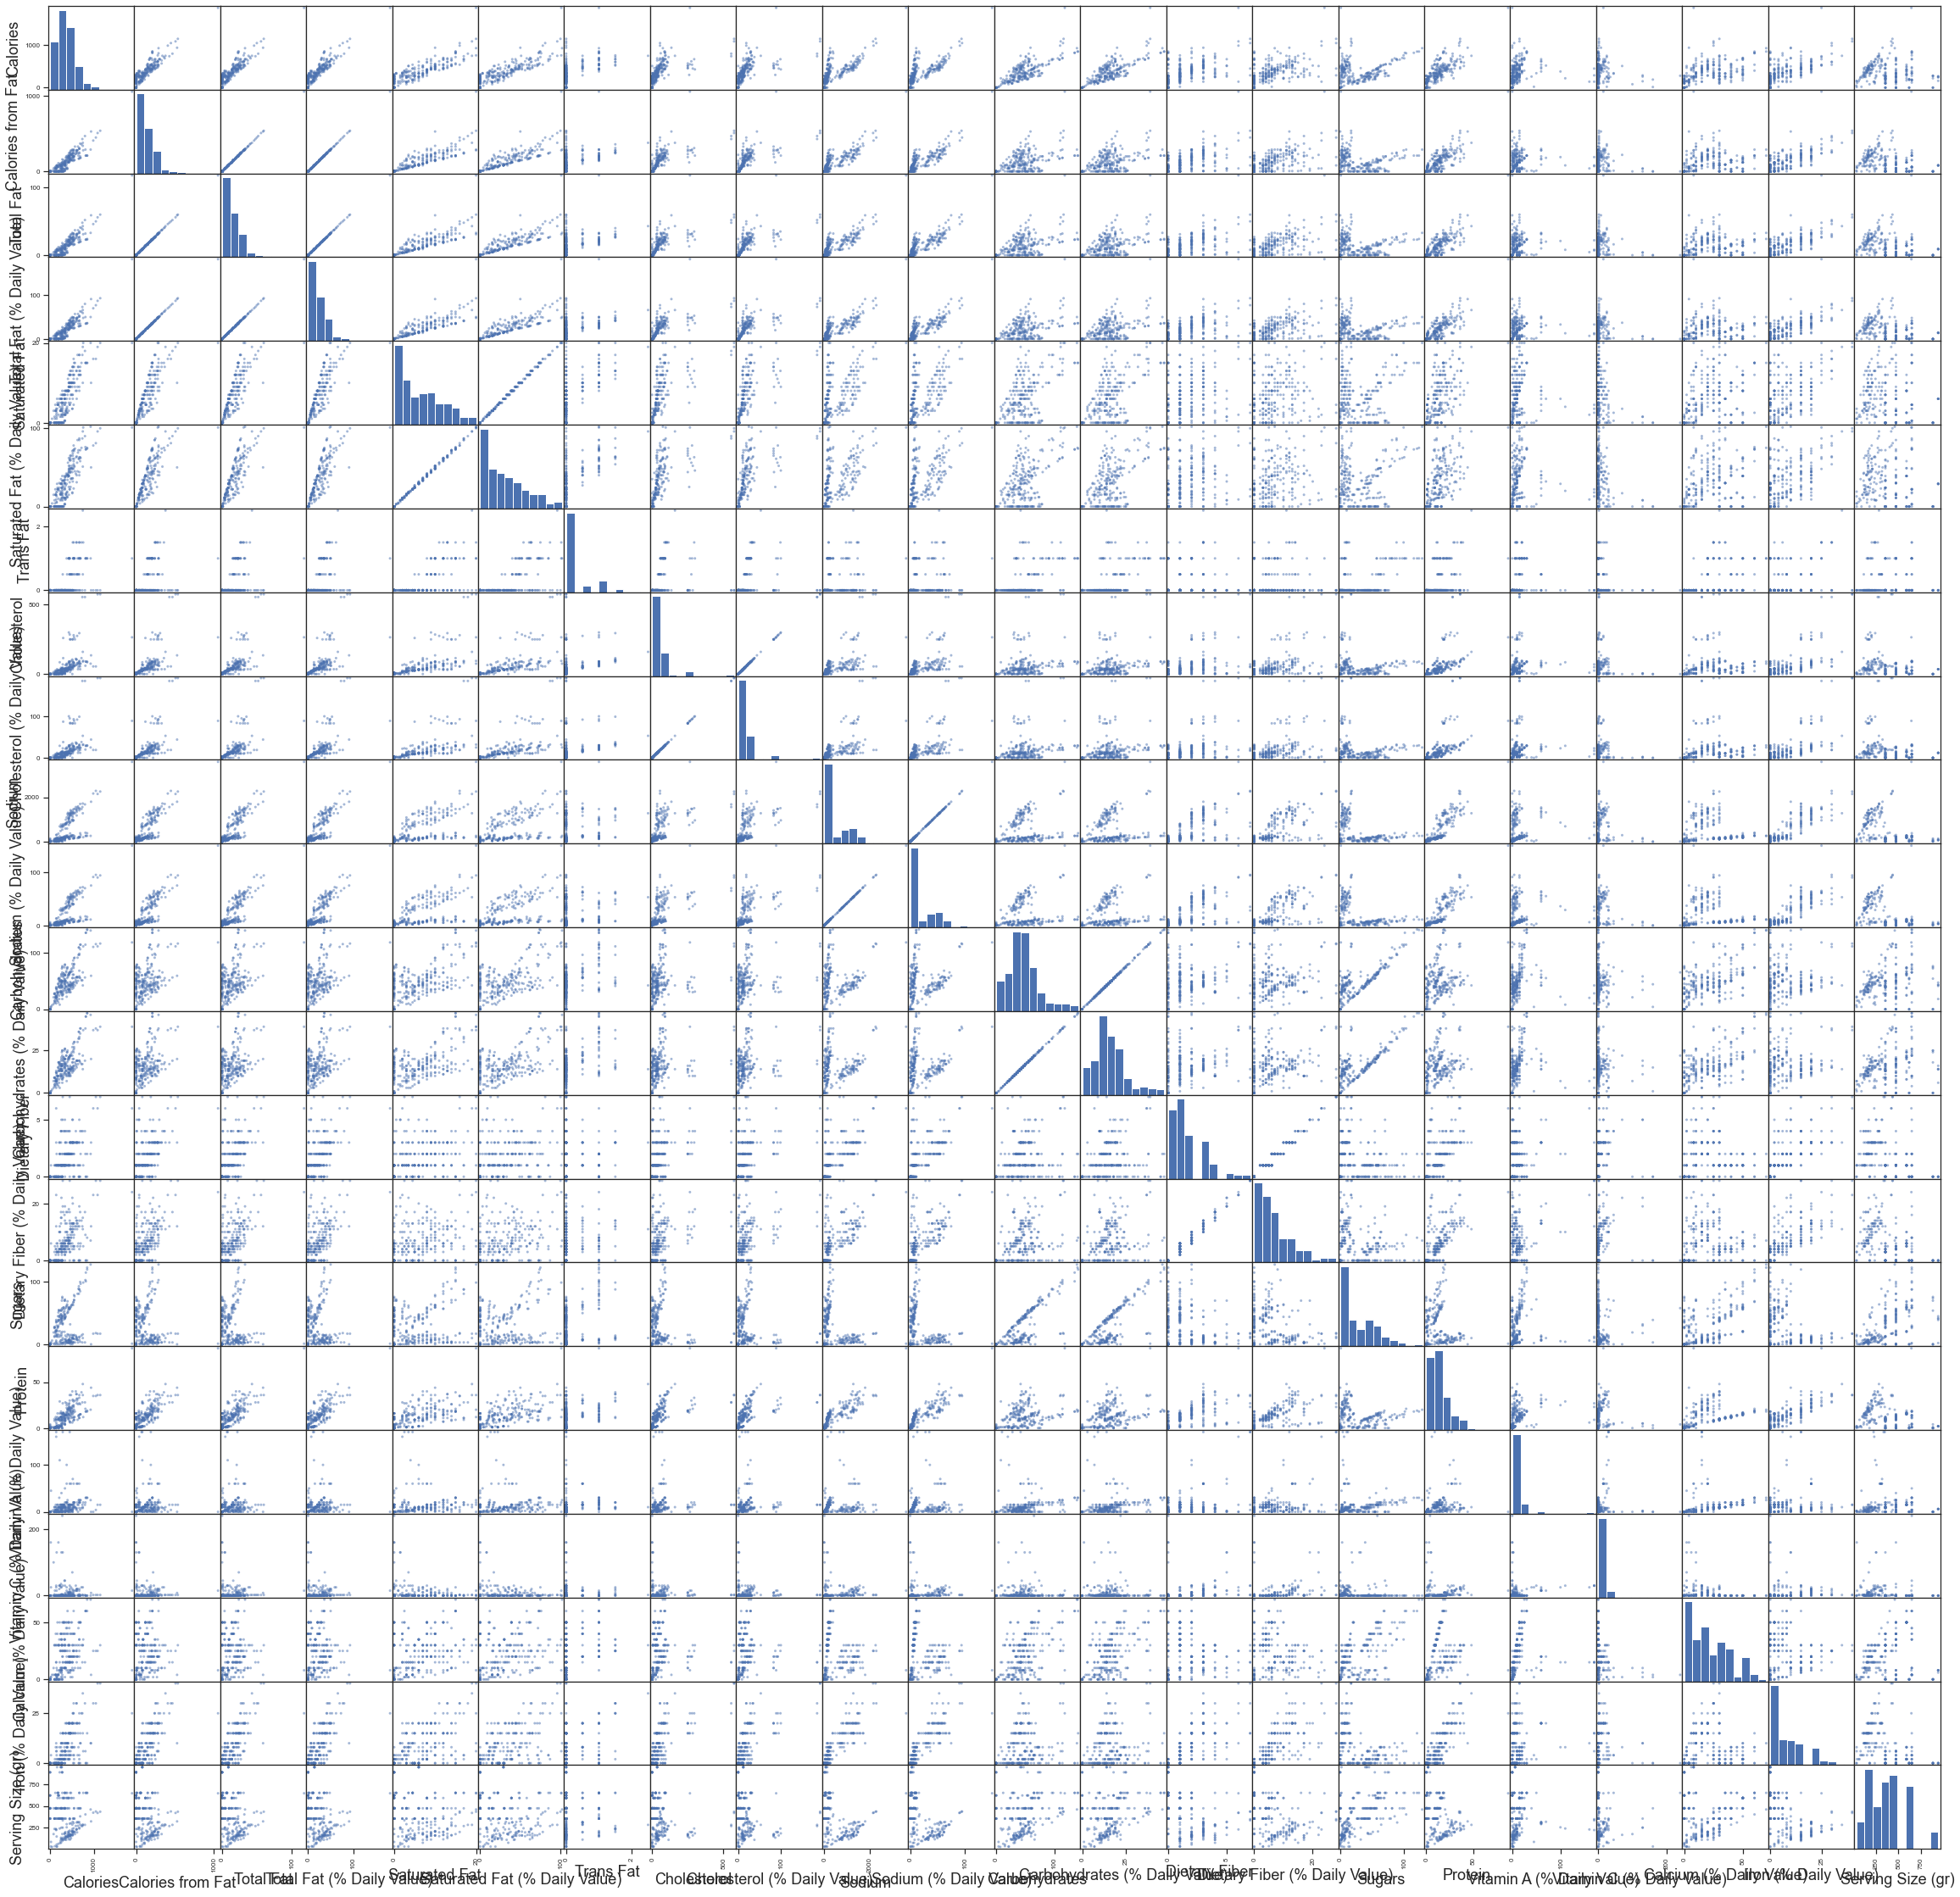

In [362]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_num,figsize =(40,40));

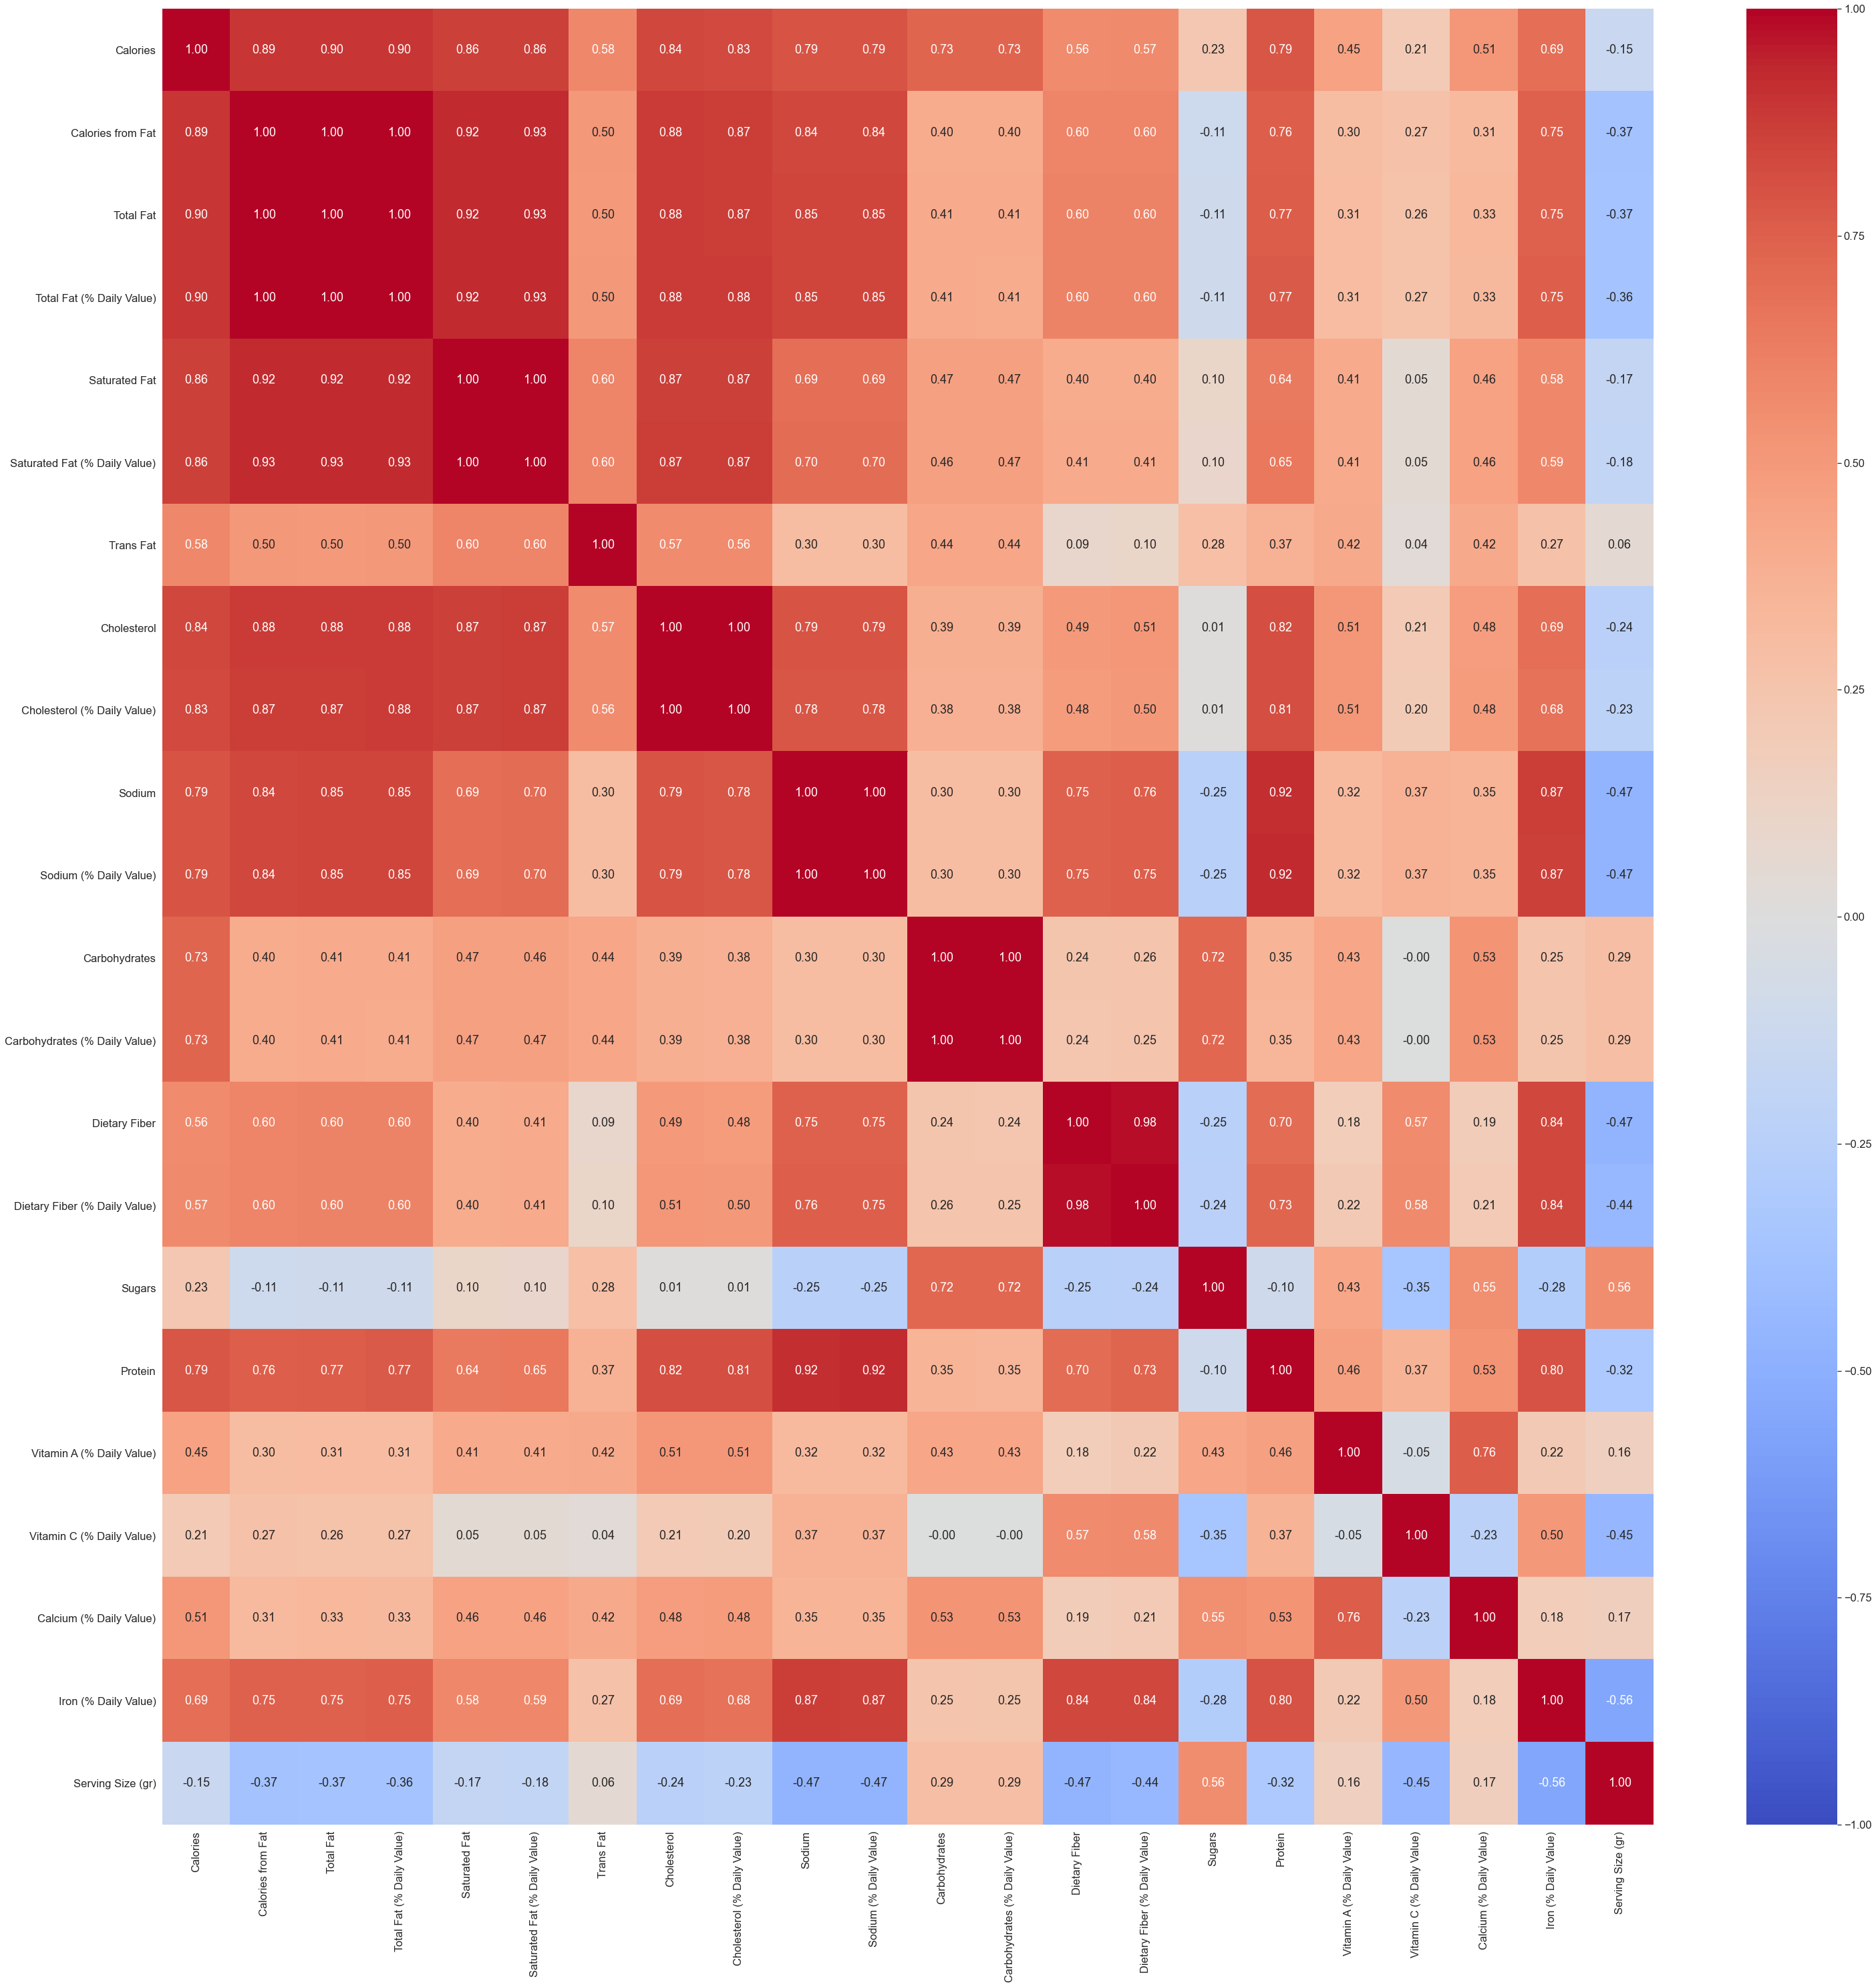

In [396]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(50, 50))
coef_spearman = df_num.corr(method="spearman")
sns.heatmap(df_num.corr(method="spearman"),vmin=-1,cmap='coolwarm',annot=True, fmt=".2f");

In [401]:
coef_spearman.head()

Calories  Calories from Fat  Total Fat  \
Calories                   1.000000           0.892919   0.896289   
Calories from Fat          0.892919           1.000000   0.998281   
Total Fat                  0.896289           0.998281   1.000000   
Total Fat (% Daily Value)  0.895954           0.998113   0.999617   
Saturated Fat              0.861900           0.924041   0.922713   

                           Total Fat (% Daily Value)  Saturated Fat  \
Calories                                    0.895954       0.861900   
Calories from Fat                           0.998113       0.924041   
Total Fat                                   0.999617       0.922713   
Total Fat (% Daily Value)                   1.000000       0.923934   
Saturated Fat                               0.923934       1.000000   

                           Saturated Fat (% Daily Value)  Trans Fat  \
Calories                                        0.864746   0.583667   
Calories from Fat                               0.926929   0.501460   
Total Fat                                       0.925631   0.498669   
Total Fat (% Daily Value)                       0.926850   0.500505   
Saturated Fat                                   0.999297   0.600031   

                           Cholesterol  Cholesterol (% Daily Value)    Sodium  \
Calories                      0.836659                     0.829277  0.791069   
Calories from Fat             0.877638                     0.873058  0.841287   
Total Fat                     0.877576                     0.872963  0.846939   
Total Fat (% Daily Value)     0.879558                     0.875017  0.848126   
Saturated Fat                 0.867185                     0.865686  0.694857   

                           ...  Carbohydrates (% Daily Value)  Dietary Fiber  \
Calories                   ...                       0.730576       0.563056   
Calories from Fat          ...                       0.400529       0.601212   
Total Fat                  ...                       0.407008       0.604973   
Total Fat (% Daily Value)  ...                       0.405786       0.604269   
Saturated Fat              ...                       0.467304       0.402959   

                           Dietary Fiber (% Daily Value)    Sugars   Protein  \
Calories                                        0.574035  0.228644  0.785161   
Calories from Fat                               0.597870 -0.111804  0.757269   
Total Fat                                       0.604190 -0.105378  0.765190   
Total Fat (% Daily Value)                       0.604137 -0.105665  0.766718   
Saturated Fat                                   0.402140  0.101617  0.643508   

                           Vitamin A (% Daily Value)  \
Calories                                    0.454331   
Calories from Fat                           0.302112   
Total Fat                                   0.310154   
Total Fat (% Daily Value)                   0.311239   
Saturated Fat                               0.413160   

                           Vitamin C (% Daily Value)  Calcium (% Daily Value)  \
Calories                                    0.207388                 0.514052   
Calories from Fat                           0.272221                 0.313536   
Total Fat                                   0.264334                 0.328229   
Total Fat (% Daily Value)                   0.265366                 0.328085   
Saturated Fat                               0.050620                 0.457108   

                           Iron (% Daily Value)  Serving Size (gr)  
Calories                               0.688430          -0.145848  
Calories from Fat                      0.746843          -0.370919  
Total Fat                              0.748857          -0.365487  
Total Fat (% Daily Value)              0.750718          -0.364353  
Saturated Fat                          0.579566          -0.174742  

[5 rows x 22 columns]

In [374]:
print("A continuación se presentan los valores correspondientes al coeficiente de correlación Spearman de cada una de las feactures que componen el dataset con respecto a la variable de salida 'Calorires':")

for i in 
print(coef_spearman['Calories'])

A continuación se presentan los valores correspondientes al coeficiente de correlación Spearman de cada una de las feactures que componen el dataset con respecto a la variable de salida 'Calorires':
Calories                         1.000000
Calories from Fat                0.892919
Total Fat                        0.896289
Total Fat (% Daily Value)        0.895954
Saturated Fat                    0.861900
Saturated Fat (% Daily Value)    0.864746
Trans Fat                        0.583667
Cholesterol                      0.836659
Cholesterol (% Daily Value)      0.829277
Sodium                           0.791069
Sodium (% Daily Value)           0.791354
Carbohydrates                    0.732479
Carbohydrates (% Daily Value)    0.730576
Dietary Fiber                    0.563056
Dietary Fiber (% Daily Value)    0.574035
Sugars                           0.228644
Protein                          0.785161
Vitamin A (% Daily Value)        0.454331
Vitamin C (% Daily Value)        0.207388
Cal

In [ ]:
print("")
print(df_num.corr(method="spearman")['Calories'])

#### 3.Supuestos de Linealidad

#### 3.1. Relación Lineal 
Se analiza la linealidad mediante scatter plot para cada relación entre variables. Para ello se define previmente un modelo de referencia:
y = x

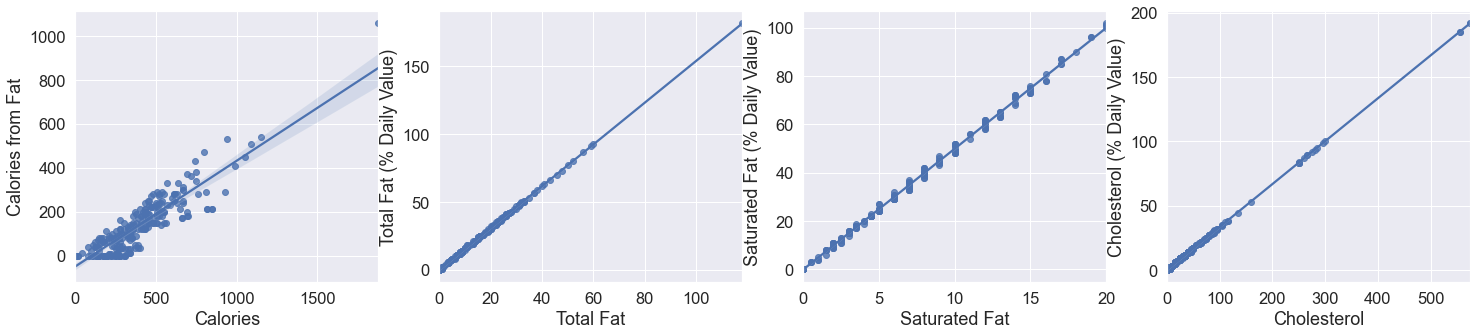

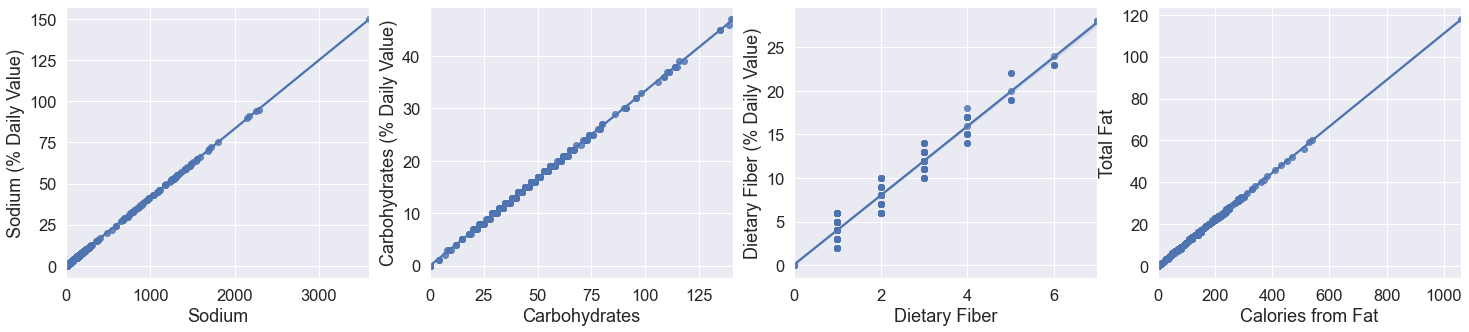

In [393]:
fig,axes = plt.subplots(1,4,figsize=(25,5))
sns.regplot(x="Calories", y="Calories from Fat", data=df_num, order=1,ax=axes[0]);
sns.regplot(x="Total Fat", y="Total Fat (% Daily Value)", data=df_num, order=1,ax=axes[1]);
sns.regplot(x="Saturated Fat", y="Saturated Fat (% Daily Value)", data=df_num, order=1,ax=axes[2]);
sns.regplot(x="Cholesterol", y="Cholesterol (% Daily Value)", data=df_num, order=1,ax=axes[3]);

fig,axes = plt.subplots(1,4,figsize=(25,5))
sns.regplot(x="Sodium", y="Sodium (% Daily Value)", data=df_num, order=1,ax=axes[0]);
sns.regplot(x="Carbohydrates", y="Carbohydrates (% Daily Value)", data=df_num, order=1,ax=axes[1]);
sns.regplot(x="Dietary Fiber", y="Dietary Fiber (% Daily Value)", data=df_num, order=1,ax=axes[2]);
sns.regplot(x="Calories from Fat", y="Total Fat", data=df_num, order=1,ax=axes[3]);


In [394]:
df_num_red = df_num.drop(['Total Fat (% Daily Value)', 'Saturated Fat (% Daily Value)', 'Cholesterol (% Daily Value)', 'Sodium (% Daily Value)', 'Carbohydrates (% Daily Value)', 'Dietary Fiber (% Daily Value)', 'Calories from Fat'], axis = 1, inplace = False)
df_num_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Calories                   260 non-null    int64  
 1   Total Fat                  260 non-null    float64
 2   Saturated Fat              260 non-null    float64
 3   Trans Fat                  260 non-null    float64
 4   Cholesterol                260 non-null    int64  
 5   Sodium                     260 non-null    int64  
 6   Carbohydrates              260 non-null    int64  
 7   Dietary Fiber              260 non-null    int64  
 8   Sugars                     260 non-null    int64  
 9   Protein                    260 non-null    int64  
 10  Vitamin A (% Daily Value)  260 non-null    int64  
 11  Vitamin C (% Daily Value)  260 non-null    int64  
 12  Calcium (% Daily Value)    260 non-null    int64  
 13  Iron (% Daily Value)       260 non-null    int64  

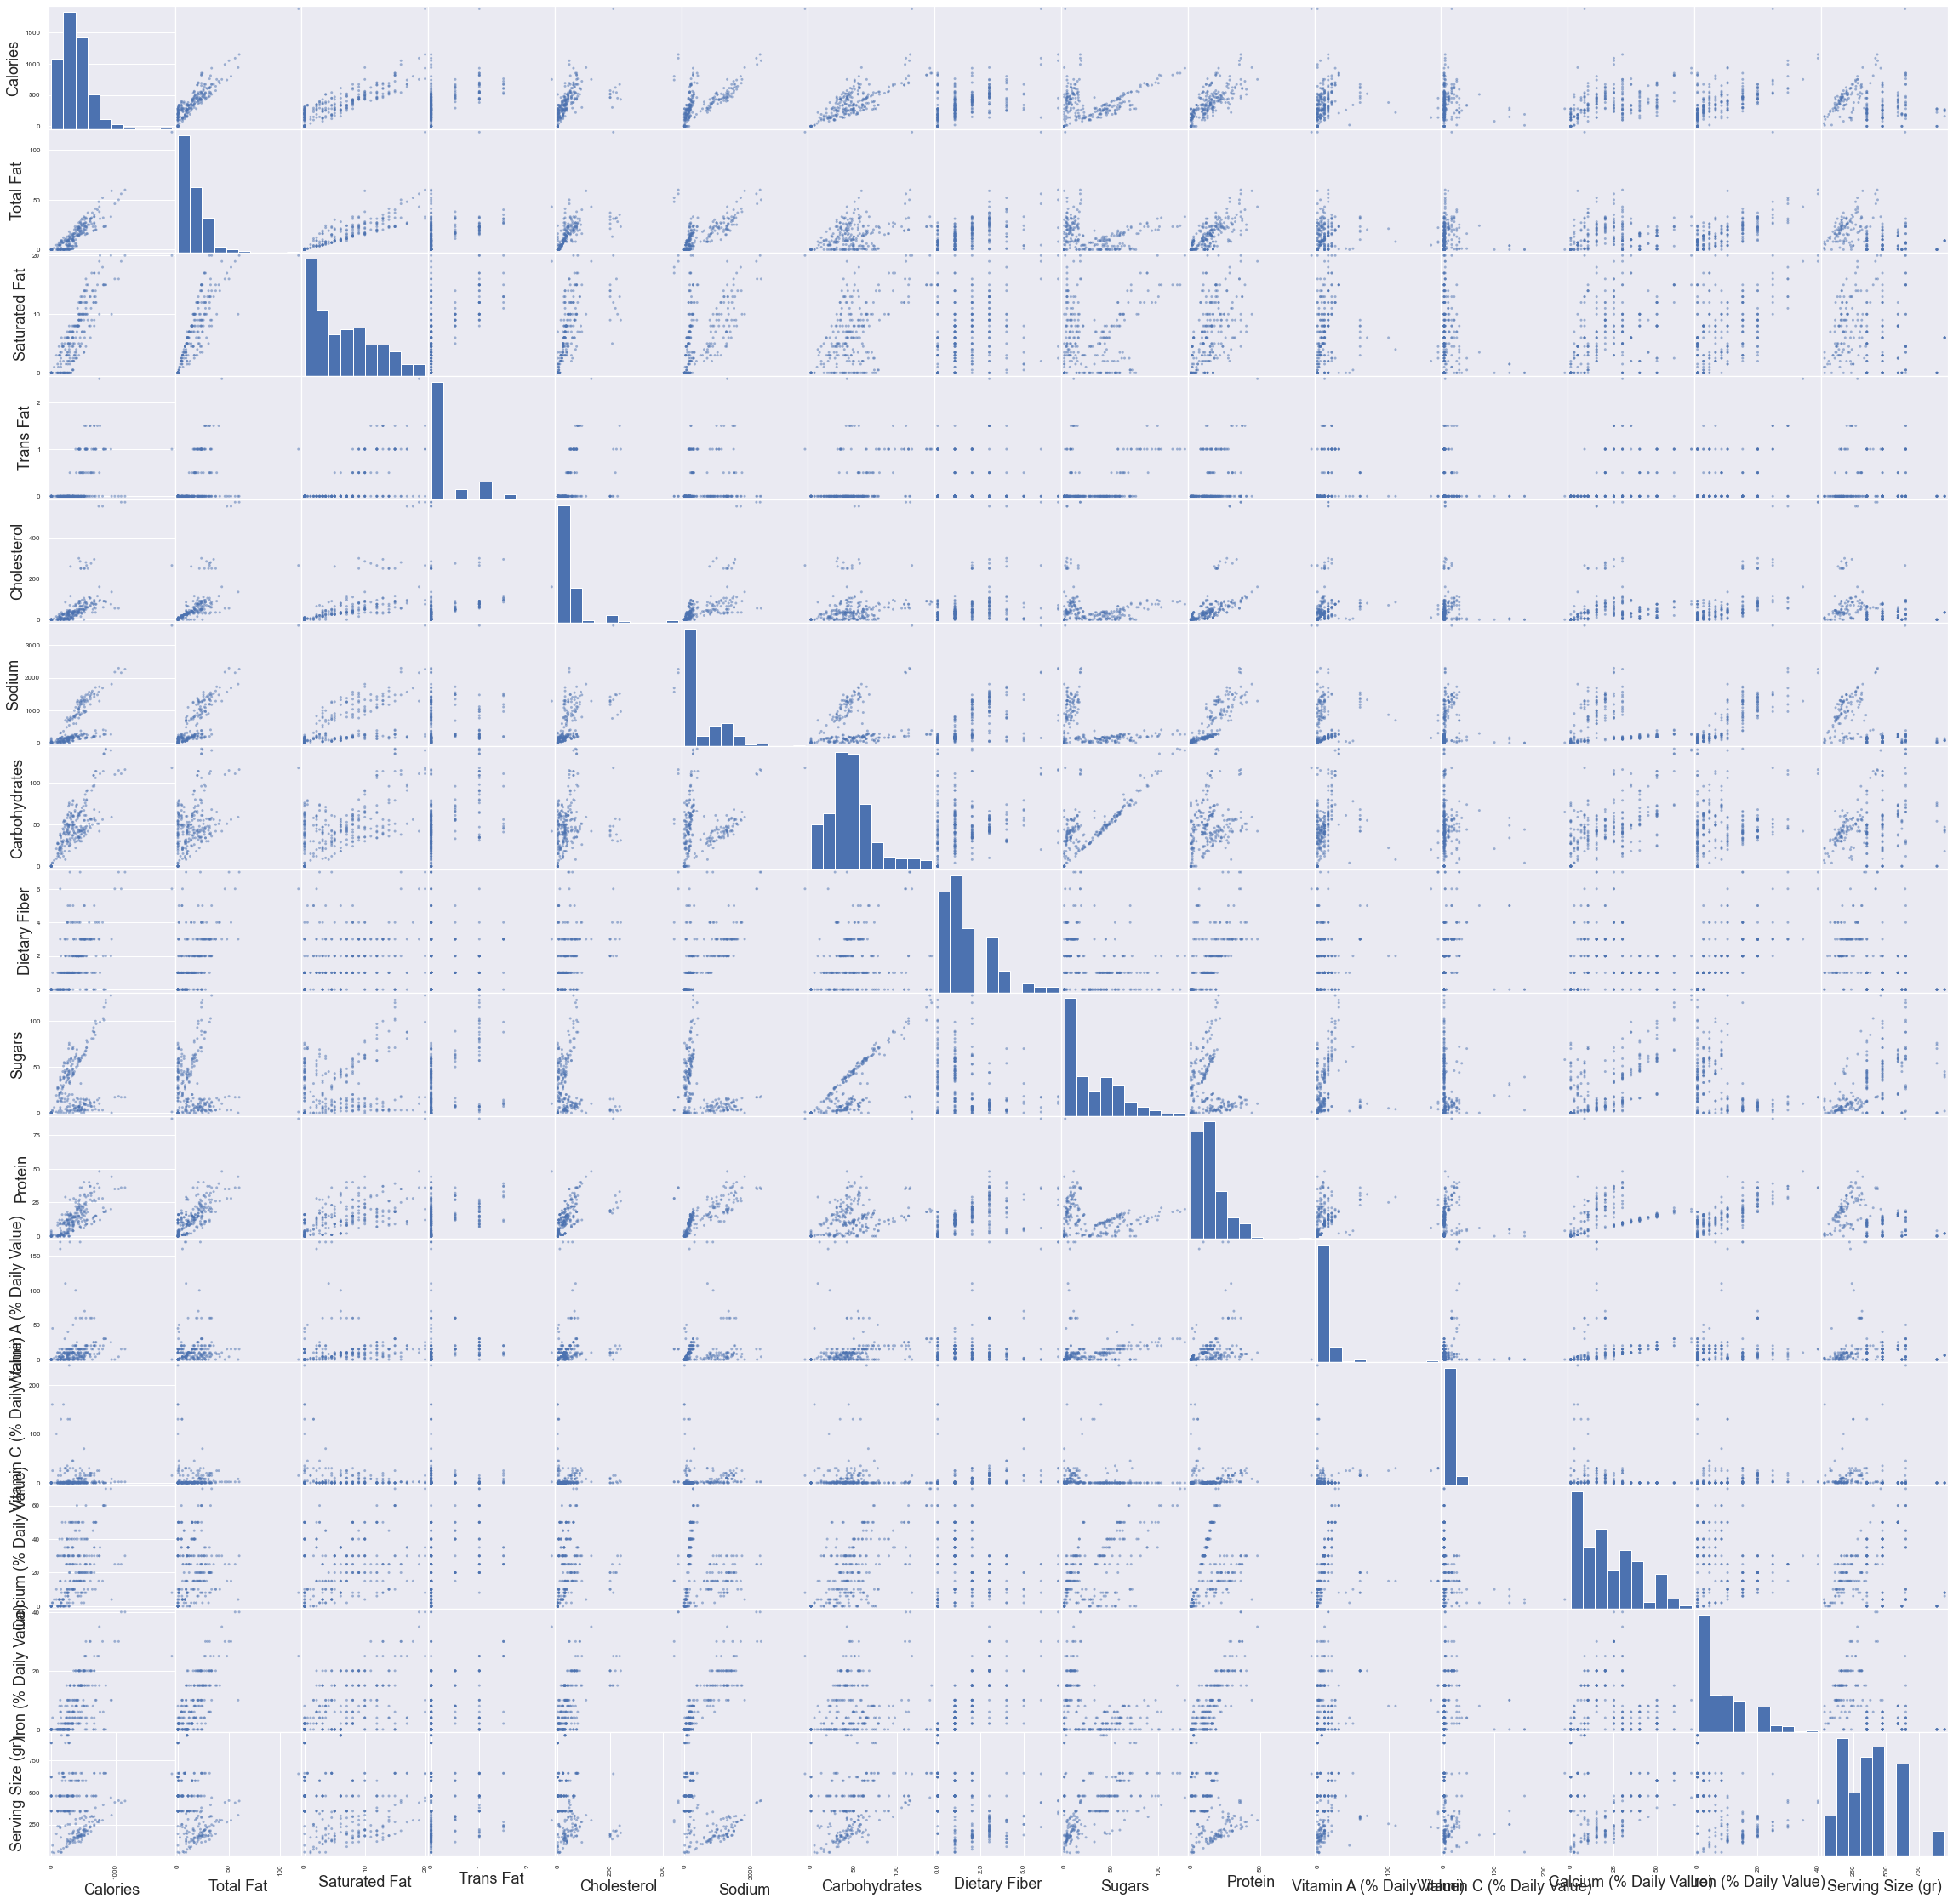

In [395]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_num_red,figsize =(40,40));

Hacer gráficos de box-plot y QQ-plot

### 3. Limpieza y preparación de datos / ingeniería de features

In [10]:
# Limpieza del dataset

df.isnull().sum()
nans = df.loc[df.isnull().sum(axis=1) >= 1, :]
print('Cantidad de filas NaN {}'.format(nans.shape[0]))
not_nans = df.loc[df.isnull().sum(axis=1) == 0, :]
print('Cantidad de filas sin NaN {}'.format(not_nans.shape[0]))
df_not_nans = not_nans

Cantidad de filas NaN 0
Cantidad de filas sin NaN 260
